In [1]:
from pandas import read_csv

tagged = dict([(p,w) for _,p,w in read_csv('train.csv').to_records()])
submit = [p for _,p,_ in read_csv('sample_submission.csv').to_records()]
join   = list(tagged.keys()) + submit
len(tagged),len(submit),len(join),list(tagged.items())[:5],submit[:5]

(25361,
 7960,
 33321,
 [('0000e88ab.jpg', 'w_f48451c'),
  ('0001f9222.jpg', 'w_c3d896a'),
  ('00029d126.jpg', 'w_20df2c5'),
  ('00050a15a.jpg', 'new_whale'),
  ('0005c1ef8.jpg', 'new_whale')],
 ['00028a005.jpg',
  '000dcf7d8.jpg',
  '000e7c7df.jpg',
  '0019c34f4.jpg',
  '001a4d292.jpg'])

In [2]:
# 确定每个图像的大小
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

def expand_path(p):
    if isfile('train/' + p): return 'train/' + p
    if isfile('test/' + p): return 'test/' + p
    return p

p2size = {}
for p in tqdm_notebook(join):
    size      = pil_image.open(expand_path(p)).size
    p2size[p] = size
len(p2size), list(p2size.items())[:5]

(33321,
 [('0000e88ab.jpg', (1050, 700)),
  ('0001f9222.jpg', (758, 325)),
  ('00029d126.jpg', (1050, 497)),
  ('00050a15a.jpg', (1050, 525)),
  ('0005c1ef8.jpg', (1050, 525))])

In [3]:
# file = open("cropping.txt",'w')
# for i in list(p2size.items()):
#     L = [str(i[0]),",0,0,0,",str(i[1][1]),",",str(i[1][0]),",0,",str(i[1][0]),",",str(i[1][1]),"\n"]
#     file.writelines(L)
# file.close()

In [4]:
import pickle
pickle_out = open("bounding-box.pickle","wb")
p2bb = {}
for i in list(p2size.items()):
    p2bb[i[0]] = (0,0,i[1][0],i[1][1])
pickle.dump(p2bb,pickle_out)
pickle_out.close()

In [5]:
p2bb['0000e88ab.jpg']

(0, 0, 1050, 700)

In [7]:
# 读取或者生成 p2h（picture to hash)
import pickle
import numpy as np
from imagehash import phash
from math import sqrt

# 对所有图像对，如果满足下列条件，则认为是重复的:
# 1) 它们具有相同的模式和大小;
# 2) 在将像素归一化为零均值和一方差之后，均方误差不超过0.1
def match(h1,h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 =  pil_image.open(expand_path(p1))
            i2 =  pil_image.open(expand_path(p2))
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1/sqrt((a1**2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2/sqrt((a2**2).mean())
            a  = ((a1 - a2)**2).mean()
            if a > 0.1: return False
    return True

if isfile('p2h.pickle'):
    with open('p2h.pickle', 'rb') as f:
        p2h = pickle.load(f)
else:
    # 计算训练和测试集中每个图像的phash。
    p2h = {}
    for p in tqdm_notebook(join):
        img    = pil_image.open(expand_path(p))
        h      = phash(img)
        p2h[p] = h

    # 查找与给定phash值关联的所有图像。
    h2ps = {}
    for p,h in p2h.items():
        if h not in h2ps: h2ps[h] = []
        if p not in h2ps[h]: h2ps[h].append(p)

    # 找到所有不同的phash值
    hs = list(h2ps.keys())

    # 如果图像足够接近，则关联两个phash值 (这部分非常慢: 算法复杂度 n^2 )
    h2h = {}
    for i,h1 in enumerate(tqdm_notebook(hs)):
        for h2 in hs[:i]:
            if h1-h2 <= 6 and match(h1, h2):
                s1 = str(h1)
                s2 = str(h2)
                if s1 < s2: s1,s2 = s2,s1
                h2h[s1] = s2

    # 将相同phash的图像组合在一起，并用字符串格式的phash替换（更快，更可读）
    for p,h in p2h.items():
        h = str(h)
        if h in h2h: h = h2h[h]
        p2h[p] = h
    
    pickle_out = open("p2h.pickle","wb")
    pickle.dump(p2h,pickle_out)
    pickle_out.close()

len(p2h), list(p2h.items())[:5]

(33321,
 [('0000e88ab.jpg', 'd26698c3271c757c'),
  ('0001f9222.jpg', 'ba8cc231ad489b77'),
  ('00029d126.jpg', 'bbcad234a52d0f0b'),
  ('00050a15a.jpg', 'c09ae7dc09f33a29'),
  ('0005c1ef8.jpg', 'd02f65ba9f74a08a')])

In [8]:
# 对于每个图像ID，生成图像列表
h2ps = {}
for p,h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)
#注意到33321张图像是如何仅使用33317个不同的图像ID。
len(h2ps),list(h2ps.items())[:5]

(33317,
 [('d26698c3271c757c', ['0000e88ab.jpg']),
  ('ba8cc231ad489b77', ['0001f9222.jpg']),
  ('bbcad234a52d0f0b', ['00029d126.jpg']),
  ('c09ae7dc09f33a29', ['00050a15a.jpg']),
  ('d02f65ba9f74a08a', ['0005c1ef8.jpg'])])

In [9]:
import matplotlib.pyplot as plt
def show_whale(imgs, per_row=2):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

In [10]:
# 对于每个图像ID，选择首选的图像
def prefer(ps):
    if len(ps) == 1: return ps[0]
    best_p = ps[0]
    best_s = p2size[best_p]
    for i in range(1, len(ps)):
        p = ps[i]
        s = p2size[p]
        if s[0]*s[1] > best_s[0]*best_s[1]: # Select the image with highest resolution
            best_p = p
            best_s = s
    return best_p

h2p = {}
for h,ps in h2ps.items(): h2p[h] = prefer(ps)
len(h2p),list(h2p.items())[:5]

(33317,
 [('d26698c3271c757c', '0000e88ab.jpg'),
  ('ba8cc231ad489b77', '0001f9222.jpg'),
  ('bbcad234a52d0f0b', '00029d126.jpg'),
  ('c09ae7dc09f33a29', '00050a15a.jpg'),
  ('d02f65ba9f74a08a', '0005c1ef8.jpg')])

In [11]:
def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    return img

In [12]:
# 从bounding box kernel中读取边界框数据（参见上面的参考资料）
# with open('bounding-box.pickle', 'rb') as f:
#     p2bb = pickle.load(f)
# p2bb = {}
# p2bb["1"] = (9,1,3,4)
# p2bb["1"]
# list(p2bb.items())[:5]

In [15]:
# 抑制导入keras时烦人的stderr输出
import sys
import platform
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')
import keras
sys.stderr = old_stderr

import random
from keras import backend as K
from keras.preprocessing.image import img_to_array,array_to_img
from scipy.ndimage import affine_transform

img_shape    = (384,384,1) # 模型使用的图像形状
anisotropy   = 2.15 # 水平压缩比
crop_margin  = 0.05 # 在边界框周围添加余量以补偿边界框的不精确性

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    """
    构建具有指定特征的变换矩阵
    """
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

def read_cropped_image(p, augment):
    """
    @param p : 要读取的图片的名称
    @param augment: 是否需要做图像增强
    @返回变换后的图像
    """
    # 如果给出了图像ID，则转换为文件名
    if p in h2p: p = h2p[p]
    size_x,size_y = p2size[p]

    # 根据边界框确定要捕获的原始图像的区域。
    x0,y0,x1,y1   = p2bb[p]
#     if p in rotate: x0, y0, x1, y1 = size_x - x1, size_y - y1, size_x - x0, size_y - y0
    dx            = x1 - x0
    dy            = y1 - y0
    x0           -= dx*crop_margin
    x1           += dx*crop_margin + 1
    y0           -= dy*crop_margin
    y1           += dy*crop_margin + 1
    if (x0 < 0     ): x0 = 0
    if (x1 > size_x): x1 = size_x
    if (y0 < 0     ): y0 = 0
    if (y1 > size_y): y1 = size_y
    dx            = x1 - x0
    dy            = y1 - y0
    if dx > dy*anisotropy:
        dy  = 0.5*(dx/anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx  = 0.5*(dy*anisotropy - dx)
        x0 -= dx
        x1 += dx

    # 生成变换矩阵
    trans = np.array([[1, 0, -0.5*img_shape[0]], [0, 1, -0.5*img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0)/img_shape[0], 0, 0], [0, (x1 - x0)/img_shape[1], 0], [0, 0, 1]]), trans)
    if augment:
        trans = np.dot(build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.8, 1.0),
            random.uniform(0.8, 1.0),
            random.uniform(-0.05*(y1 - y0), 0.05*(y1 - y0)),
            random.uniform(-0.05*(x1 - x0), 0.05*(x1 - x0))
            ), trans)
    trans = np.dot(np.array([[1, 0, 0.5*(y1 + y0)], [0, 1, 0.5*(x1 + x0)], [0, 0, 1]]), trans)

    # 读取图像，转换为黑白再转换为numpy数组
    img   = read_raw_image(p).convert('L')
    img   = img_to_array(img)

    # 使用仿射变换
    matrix = trans[:2,:2]
    offset = trans[:2,2]
    img    = img.reshape(img.shape[:-1])
    img    = affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant', cval=np.average(img))
    img    = img.reshape(img_shape)

    # 归一化为零均值和单位方差
    img  -= np.mean(img, keepdims=True)
    img  /= np.std(img, keepdims=True) + K.epsilon()
    return img

def read_for_training(p):
    """
    使用数据增强（随机变换）读取和预处理图像。
    """
    return read_cropped_image(p, True)

def read_for_validation(p):
    """
    在没有数据增强的情况下读取和预处理图像（用于测试）。
    """
    return read_cropped_image(p, False)

# p = list(tagged.keys())[312]
# imgs = [
#     read_raw_image(p),
#     array_to_img(read_for_validation(p)),
#     array_to_img(read_for_training(p))
# ]
# show_whale(imgs, per_row=3)

In [35]:
from keras import regularizers
from keras.optimizers import Adam
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, Lambda, MaxPooling2D, Reshape
from keras.models import Model

def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y) # 减少特征数量
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y) # 扩展特征域
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y) # 无激活函数 # 恢复原始特征的数量
    y = Add()([x,y]) # Add the bypass connection
    y = Activation('relu')(y)
    return y

def build_model(lr, l2, activation='sigmoid'):

    ##############
    # BRANCH MODEL
    ##############
    regul  = regularizers.l2(l2)
    optim  = Adam(lr=lr)
    kwargs = {'padding':'same', 'kernel_regularizer':regul}

    inp = Input(shape=img_shape) # 384x384x1
    x   = Conv2D(64, (9,9), strides=2, activation='relu', **kwargs)(inp)

    x   = MaxPooling2D((2, 2), strides=(2, 2))(x) # 96x96x64
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3,3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1,1), activation='relu', **kwargs)(x) # 48x48x128
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 24x24x128
    x = BatchNormalization()(x)
    x = Conv2D(256, (1,1), activation='relu', **kwargs)(x) # 24x24x256
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 12x12x256
    x = BatchNormalization()(x)
    x = Conv2D(384, (1,1), activation='relu', **kwargs)(x) # 12x12x384
    for _ in range(4): x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1,1), activation='relu', **kwargs)(x) # 6x6x512
    for _ in range(4): x = subblock(x, 128, **kwargs)

    x             = GlobalMaxPooling2D()(x) # 512
    branch_model  = Model(inp, x)

    ############
    # HEAD MODEL
    ############
    mid        = 32
    xa_inp     = Input(shape=branch_model.output_shape[1:])
    xb_inp     = Input(shape=branch_model.output_shape[1:])
    x1         = Lambda(lambda x : x[0]*x[1])([xa_inp, xb_inp])
    x2         = Lambda(lambda x : x[0] + x[1])([xa_inp, xb_inp])
    x3         = Lambda(lambda x : K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4         = Lambda(lambda x : K.square(x))(x3)
    x          = Concatenate()([x1, x2, x3, x4])
    x          = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # 使用合适的步幅，让2D卷积实现具有共享权重的特征神经网络.
    x          = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x          = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x          = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x          = Flatten(name='flatten')(x)

    # Dense layer的实现为加权和.
    x          = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # 通过在每个输入图像上调用branch model来构建完整模型,
    # 然后是生成512个向量的head model.
    img_a      = Input(shape=img_shape)
    img_b      = Input(shape=img_shape)
    xa         = branch_model(img_a)
    xb         = branch_model(img_b)
    x          = head_model([xa, xb])
    model      = Model([img_a, img_b], x)
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model

model, branch_model, head_model = build_model(64e-5,0)
head_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512)          0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None

In [36]:
# from keras.utils import plot_model
# plot_model(head_model, to_file='head-model.png')
# pil_image.open('head-model.png')

In [37]:
# 找到与图像ID关联的所有鲸鱼。 它可能不明确，因为重复的图像可能有不同的鲸鱼ID。
h2ws = {}
new_whale = 'new_whale'
for p,w in tagged.items():
    if w != new_whale: # 仅使用已识别的鲸鱼
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h,ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)
len(h2ws)

15696

In [38]:
# 对于每条鲸鱼，找到明确的图像ID。
w2hs = {}
for h,ws in h2ws.items():
    w = ws[0]
    if w not in w2hs: w2hs[w] = []
    if h not in w2hs[w]: w2hs[w].append(h)
for w,hs in w2hs.items():
    if len(hs) > 1:
        w2hs[w] = sorted(hs)
len(w2hs)


5004

In [39]:
# 获取训练图像列表，里面只保留至少有两个图像的鲸鱼
train = [] # A list of training image ids
for hs in w2hs.values():
    if len(hs) > 1:
        train += hs
random.shuffle(train)
train_set = set(train)

w2ts = {} # 将训练中的图像ID与每个鲸鱼ID相关联。
for w,hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts: w2ts[w] = []
            if h not in w2ts[w]: w2ts[w].append(h)
for w,ts in w2ts.items(): w2ts[w] = np.array(ts)

t2i = {} # 训练图像ID在训练集中的位置
for i,t in enumerate(train): t2i[t] = i

len(train),len(w2ts)

(13623, 2931)

In [40]:
from keras.utils import Sequence

# 首先尝试使用更快的lapjv解决Linear Assignment Problem。
# 在我写这篇文章时，带有自定义包的kaggle kernel无法提交。
# scipy可以当做备用，但在时间限制下运行此kernel太慢
# 使用scipy进行数据分区来作为一种解决方法。
# 因为算法复杂度为O(n^3), 分成小块会快的多，但生成的不是真正得解决方案。
try:
    from lap import lapjv
    segment = False
except ImportError:
    print('Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment')
    segment = True
    from scipy.optimize import linear_sum_assignment

class TrainingData(Sequence):
    def __init__(self, score, steps=1000, batch_size=32):
        """
        @param score 图片匹配的cost matrix
        @param steps epoch数，用来设计score matrix
        """
        super(TrainingData, self).__init__()
        self.score      = -score # 最大化分数与最小化负分数相同。
        self.steps      = steps
        self.batch_size = batch_size
        for ts in w2ts.values():
            idxs = [t2i[t] for t in ts]
            for i in idxs:
                for j in idxs:
                    self.score[i,j] = 10000.0 # 为匹配鲸鱼设置一个很大的值 - 消除了这种潜在的配对
        self.on_epoch_end()
    def __getitem__(self, index):
        start = self.batch_size*index
        end   = min(start + self.batch_size, len(self.match) + len(self.unmatch))
        size  = end - start
        assert size > 0
        a     = np.zeros((size,) + img_shape, dtype=K.floatx())
        b     = np.zeros((size,) + img_shape, dtype=K.floatx())
        c     = np.zeros((size,1), dtype=K.floatx())
        j     = start//2
        for i in range(0, size, 2):
            a[i,  :,:,:] = read_for_training(self.match[j][0])
            b[i,  :,:,:] = read_for_training(self.match[j][1])
            c[i,  0    ] = 1 # This is a match
            a[i+1,:,:,:] = read_for_training(self.unmatch[j][0])
            b[i+1,:,:,:] = read_for_training(self.unmatch[j][1])
            c[i+1,0    ] = 0 # Different whales
            j           += 1
        return [a,b],c
    def on_epoch_end(self):
        if self.steps <= 0: return # 跳过最后一个epoch
        self.steps     -= 1
        self.match      = []
        self.unmatch    = []
        if segment:
            # 使用较慢的scipy，用较小的batch
            # 因为算法复杂度为O(n^3), 小batch更快
            # 然而，这并不能找到真正的最优解，只是近似值。
            tmp   = []
            batch = 512
            for start in range(0, score.shape[0], batch):
                end = min(score.shape[0], start + batch)
                _, x = linear_sum_assignment(self.score[start:end, start:end])
                tmp.append(x + start)
            x = np.concatenate(tmp)
        else:
            _,_,x = lapjv(self.score) # 解决 linear assignment problem
        y = np.arange(len(x),dtype=np.int32)

        # 计算匹配鲸鱼的derangement
        for ts in w2ts.values():
            d = ts.copy()
            while True:
                random.shuffle(d)
                if not np.any(ts == d): break
            for ab in zip(ts,d): self.match.append(ab)

        # Construct unmatched whale pairs from the LAP solution.
        for i,j in zip(x,y):
            if i == j:
                print(self.score)
                print(x)
                print(y)
                print(i,j)
            assert i != j
            self.unmatch.append((train[i],train[j]))

        # Force a different choice for an eventual next epoch.
        self.score[x,y] = 10000.0
        self.score[y,x] = 10000.0
        random.shuffle(self.match)
        random.shuffle(self.unmatch)
        # print(len(self.match), len(train), len(self.unmatch), len(train))
        assert len(self.match) == len(train) and len(self.unmatch) == len(train)
    def __len__(self):
        return (len(self.match) + len(self.unmatch) + self.batch_size - 1)//self.batch_size

Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment


In [41]:
# 对一批32个随机cost matrix进行测试。
score = np.random.random_sample(size=(len(train),len(train)))
data = TrainingData(score)
(a, b), c = data[0]
a.shape, b.shape, c.shape

((32, 384, 384, 1), (32, 384, 384, 1), (32, 1))

In [42]:
score

array([[0.19127569, 0.52037468, 0.96369329, ..., 0.59323763, 0.04130614,
        0.42468104],
       [0.77022083, 0.45064396, 0.83011305, ..., 0.42123038, 0.58447528,
        0.63608218],
       [0.88669158, 0.35614876, 0.46711245, ..., 0.23004899, 0.0769087 ,
        0.73437453],
       ...,
       [0.97057426, 0.66331645, 0.70139855, ..., 0.05956547, 0.49886732,
        0.07763331],
       [0.80354133, 0.7501756 , 0.11098333, ..., 0.74373991, 0.73829377,
        0.27770285],
       [0.56827651, 0.08697942, 0.70835912, ..., 0.08096393, 0.14687042,
        0.37556016]])

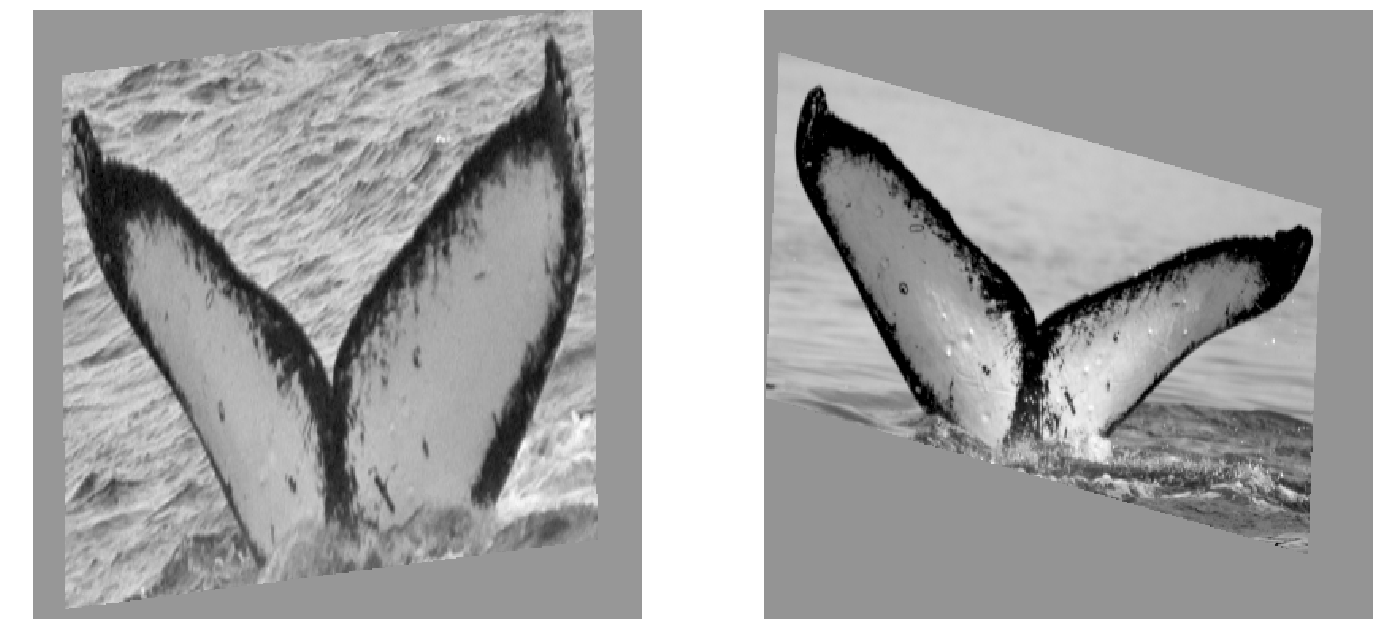

In [43]:
# 第一对为匹配的鲸鱼
imgs = [array_to_img(a[0]), array_to_img(b[0])]
show_whale(imgs, per_row=2)

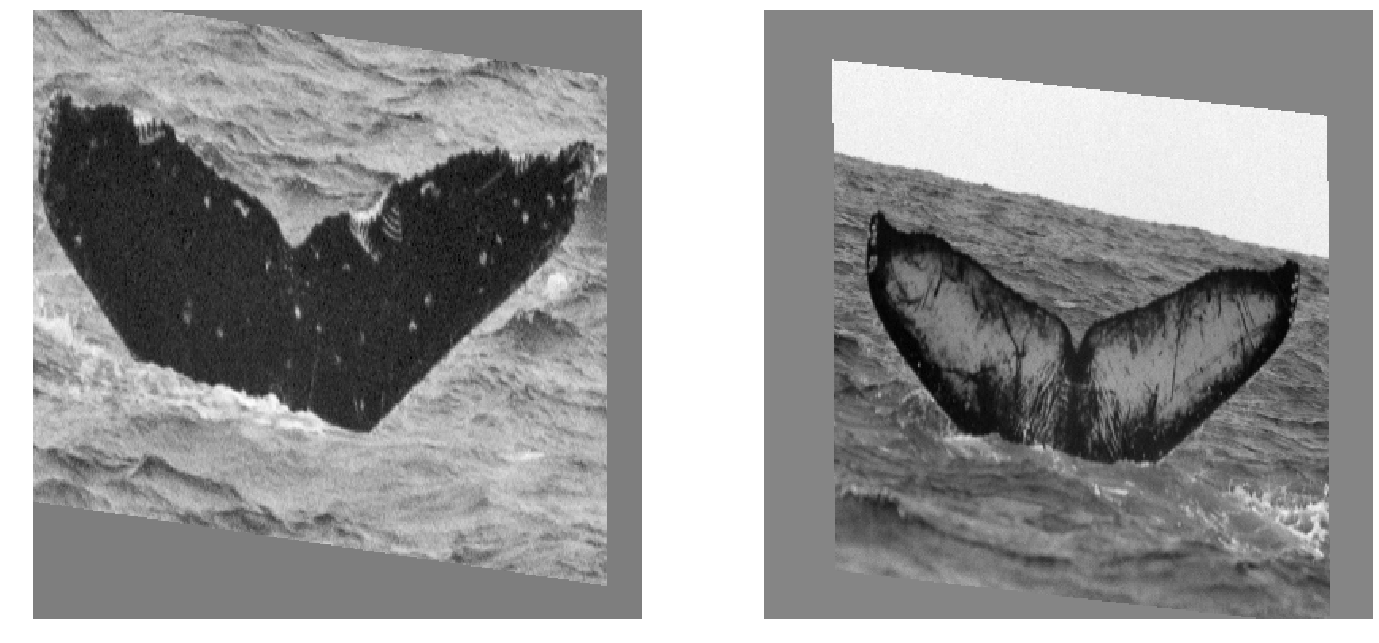

In [44]:
# 第二对为不匹配的鲸鱼
imgs = [array_to_img(a[1]), array_to_img(b[1])]
show_whale(imgs, per_row=2)

In [45]:
# Keras生成器，仅评估branch model
class FeatureGen(Sequence):
    def __init__(self, data, batch_size=64, verbose=1):
        super(FeatureGen, self).__init__()
        self.data       = data
        self.batch_size = batch_size
        self.verbose    = verbose
        if self.verbose > 0: self.progress = tqdm_notebook(total=len(self), desc='Features')
    def __getitem__(self, index):
        start = self.batch_size*index
        size  = min(len(self.data) - start, self.batch_size)
        a     = np.zeros((size,) + img_shape, dtype=K.floatx())
        for i in range(size): a[i,:,:,:] = read_for_validation(self.data[start + i])
        if self.verbose > 0: 
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return a
    def __len__(self):
        return (len(self.data) + self.batch_size - 1)//self.batch_size

# Keras生成器，用于评估head model上已预先计算的特征。
# 如果y为None，则仅计算cost matrix的上三角矩阵。
class ScoreGen(Sequence):
    def __init__(self, x, y=None, batch_size=2048, verbose=1):
        super(ScoreGen, self).__init__()
        self.x          = x
        self.y          = y
        self.batch_size = batch_size
        self.verbose    = verbose
        if y is None:
            self.y           = self.x
            self.ix, self.iy = np.triu_indices(x.shape[0],1)
        else:
            self.iy, self.ix = np.indices((y.shape[0],x.shape[0]))
            self.ix          = self.ix.reshape((self.ix.size,))
            self.iy          = self.iy.reshape((self.iy.size,))
        self.subbatch = (len(self.x) + self.batch_size - 1)//self.batch_size
        if self.verbose > 0: self.progress = tqdm_notebook(total=len(self), desc='Scores')
    def __getitem__(self, index):
        start = index*self.batch_size
        end   = min(start + self.batch_size, len(self.ix))
        a     = self.y[self.iy[start:end],:]
        b     = self.x[self.ix[start:end],:]
        if self.verbose > 0: 
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return [a,b]
    def __len__(self):
        return (len(self.ix) + self.batch_size - 1)//self.batch_size

In [46]:
from keras_tqdm import TQDMNotebookCallback

def set_lr(model, lr):
    K.set_value(model.optimizer.lr, float(lr))

def get_lr(model):
    return K.get_value(model.optimizer.lr)

def score_reshape(score, x, y=None):
    """
    将packed matrix的'得分'转换为方阵。
    @param score the packed matrix
    @param x 第一张图像的特征张量
    @param y 第二张图像的张量，如果与x不同
    @结果为方阵
    """
    if y is None:
        # 当y为None时，得分是packed matrix的上三角矩阵。
        # 解包, 并转置形成对称的下三角矩阵。
        m = np.zeros((x.shape[0],x.shape[0]), dtype=K.floatx())
        m[np.triu_indices(x.shape[0],1)] = score.squeeze()
        m += m.transpose()
    else:
        m        = np.zeros((y.shape[0],x.shape[0]), dtype=K.floatx())
        iy,ix    = np.indices((y.shape[0],x.shape[0]))
        ix       = ix.reshape((ix.size,))
        iy       = iy.reshape((iy.size,))
        m[iy,ix] = score.squeeze()
    return m

def compute_score(verbose=1):
    """
    Compute the score matrix by scoring every pictures from the training set against every other picture O(n^2).
    """我I 
    features = branch_model.predict_generator(FeatureGen(train, verbose=verbose), max_queue_size=12, workers=6, verbose=0)
    score    = head_model.predict_generator(ScoreGen(features, verbose=verbose), max_queue_size=12, workers=6, verbose=0)
    score    = score_reshape(score, features)
    return features, score

def make_steps(step, ampl):
    """
    执行训练
    @param step 训练的epoch数。
    @param ampl K值, score matrix的随机分量。
    """
    global w2ts, t2i, steps, features, score, histories

    # 打乱训练图片
    random.shuffle(train)

    # 将鲸鱼id映射到相关的训练图片的hash表上去。
    w2ts = {}
    for w,hs in w2hs.items():
        for h in hs:
            if h in train_set:
                if w not in w2ts: w2ts[w] = []
                if h not in w2ts[w]: w2ts[w].append(h)
    for w,ts in w2ts.items(): w2ts[w] = np.array(ts)

    # 将训练图片hash值映射到'train'数组中的索引
    t2i  = {}
    for i,t in enumerate(train): t2i[t] = i    

    # 计算每个图片对的匹配分数
    features, score = compute_score()

    # 训练模型'step'个epoch
    history = model.fit_generator(
        TrainingData(score + ampl*np.random.random_sample(size=score.shape), steps=step, batch_size=32),
        initial_epoch=steps, epochs=steps + step, max_queue_size=12, workers=6, verbose=0,
        callbacks=[
            TQDMNotebookCallback(leave_inner=True, metric_format='{value:0.3f}')
        ]).history
    steps += step

    # 收集历史数据
    history['epochs'] = steps
    history['ms'    ] = np.mean(score)
    history['lr'    ] = get_lr(model)
    print(history['epochs'],history['lr'],history['ms'])
    histories.append(history)

In [47]:
model_name = 'mpiotte-standard'
histories  = []
steps      = 0

In [48]:
if isfile('mpiotte-standard.model'):
    tmp = keras.models.load_model('mpiotte-standard.model')
    model.set_weights(tmp.get_weights())
else:
    # epoch -> 10
    make_steps(10, 1000)
    ampl = 100.0
    model.save('mpiotte-standard.model')
#     for _ in range(1):
#         print('noise ampl.  = ', ampl)
#         make_steps(1, ampl)
#         ampl = max(1.0, 100**-0.1*ampl)
   


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



10 0.00064 0.50732535
noise ampl.  =  100.0


KeyboardInterrupt: 

In [49]:
model.save('mpiotte-standard.model')

In [51]:
histories

[{'loss': [0.7058692254666967,
   0.6179146612652211,
   0.5528951718892451,
   0.5046413820815281,
   0.4698132978201105,
   0.4300320340762236,
   0.40380674674981215,
   0.3834190003074564,
   0.36770731542355983,
   0.35002996675560216],
  'binary_crossentropy': [0.7058692254666967,
   0.6179146612652211,
   0.5528951718892451,
   0.5046413820815281,
   0.4698132978201105,
   0.4300320340762236,
   0.40380674674981215,
   0.3834190003074564,
   0.36770731542355983,
   0.35002996675560216],
  'acc': [0.5401526829626367,
   0.6501137781736478,
   0.7115539895895775,
   0.7481098142934163,
   0.7738016589678639,
   0.797474858690479,
   0.8170373632739331,
   0.8254789693812516,
   0.8342141965705638,
   0.8451882845100779],
  'epochs': 10,
  'ms': 0.50732535,
  'lr': 0.00064}]

In [52]:
tmp = keras.models.load_model('mpiotte-standard.model')
model.set_weights(tmp.get_weights())
def prepare_submission(threshold, filename):
    """
    Generate a Kaggle submission file.
    @param threshold the score given to 'new_whale'
    @param filename the submission file name
    """
    vtop = 0
    vhigh = 0
    pos = [0, 0, 0, 0, 0, 0]
    with open(filename, 'wt', newline='\n') as f:
        f.write('Image,Id\n')
        for i, p in enumerate(tqdm(submit)):
            t = []
            s = set()
            a = score[i, :]
            for j in list(reversed(np.argsort(a))):
                h = known[j]
                if a[j] < threshold and new_whale not in s:
                    pos[len(t)] += 1
                    s.add(new_whale)
                    t.append(new_whale)
                    if len(t) == 5: break;
                for w in h2ws[h]:
                    assert w != new_whale
                    if w not in s:
                        if a[j] > 1.0:
                            vtop += 1
                        elif a[j] >= threshold:
                            vhigh += 1
                        s.add(w)
                        t.append(w)
                        if len(t) == 5: break;
                if len(t) == 5: break;
            if new_whale not in s: pos[5] += 1
            assert len(t) == 5 and len(s) == 5
            f.write(p + ',' + ' '.join(t[:5]) + '\n')
    return vtop, vhigh, pos

In [54]:
# Find elements from training sets not 'new_whale'
import time
tic = time.time()
h2ws = {}
for p, w in tagged.items():
    if w != new_whale:  # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
known = sorted(list(h2ws.keys()))

# Dictionary of picture indices
h2i = {}
for i, h in enumerate(known): h2i[h] = i

# Evaluate the model.
fknown = branch_model.predict_generator(FeatureGen(known), max_queue_size=20, workers=10, verbose=0)
fsubmit = branch_model.predict_generator(FeatureGen(submit), max_queue_size=20, workers=10, verbose=0)
score = head_model.predict_generator(ScoreGen(fknown, fsubmit), max_queue_size=20, workers=10, verbose=0)
score = score_reshape(score, fknown, fsubmit)

# Generate the subsmission file.
prepare_submission(0.99, 'submission.csv')
toc = time.time()
print("Submission time: ", (toc - tic) / 60.)

NameError: name 'tqdm' is not defined

In [58]:
from tqdm import tqdm_notebook as tqdm

In [59]:
prepare_submission(0.99, 'submission.csv')
toc = time.time()
print("Submission time: ", (toc - tic) / 60.)

Submission time:  147.73748900492987
